### Exploring Initial Datasets for Project
This notebook is for exploration of 3 key datasets data for final MS Project:
    1. U.S. Census Designated Places (CDPs)
    2. Centers for Disease Control Social Vulnerability Index (SVIs) at the tract level
    3. Wildfire Hazard Potential (WHP) for the United States

In [47]:
# import modules 
import numpy, matplotlib, pandas, pandas, fiona
import geopandas as gpd
import rasterio as rio
from matplotlib import pyplot
from rasterio.plot import show, show_hist
import shapely
from shapely.geometry import Polygon, LineString
import rasterstats as rs
import matplotlib.pyplot as plt
import mapclassify

#change default figure size
plt.rcParams['figure.figsize'] = (12,12)

#### Read in CDPs as GeoDataframe

In [43]:
# load census designated places shapefile
cdps_raw = gpd.read_file("C:/NewMapsPlus/Map698/us-communities-fire/data/cb_2020_us_place_500k.zip")

In [24]:
# inspect
type(cdps_raw)

geopandas.geodataframe.GeoDataFrame

In [25]:
# get file info
cdps_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32188 entries, 0 to 32187
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     32188 non-null  object  
 1   PLACEFP     32188 non-null  object  
 2   PLACENS     32188 non-null  object  
 3   AFFGEOID    32188 non-null  object  
 4   GEOID       32188 non-null  object  
 5   NAME        32188 non-null  object  
 6   NAMELSAD    32188 non-null  object  
 7   STUSPS      32188 non-null  object  
 8   STATE_NAME  32188 non-null  object  
 9   LSAD        32188 non-null  object  
 10  ALAND       32188 non-null  int64   
 11  AWATER      32188 non-null  int64   
 12  geometry    32188 non-null  geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 3.2+ MB


In [26]:
# determine coordinate reference system
cdps_raw.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
# write a geoJSON copy of the shapefile to disk
with open('data\cdps.json', 'w') as f:
          f.write(cdps_raw.to_json())

In [28]:
# read the data
cdps = gpd.read_file('data/cdps.json')
cdps.head()

,id,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,NAMELSAD,PLACEFP,PLACENS,STATEFP,STATE_NAME,STUSPS,geometry
0,0,1600000US1228575,2728657,0,1228575,25,Hampton,Hampton city,28575,02403791,12,Florida,FL,"POLYGON ((-82.15433 29.86419, -82.14682 29.864..."
1,1,1600000US1200625,2731534,49685,1200625,43,Alford,Alford town,00625,02405131,12,Florida,FL,"POLYGON ((-85.40333 30.70450, -85.39543 30.704..."
2,2,1600000US1226050,442668,54824,1226050,43,Glen Ridge,Glen Ridge town,26050,02406576,12,Florida,FL,"POLYGON ((-80.08267 26.67634, -80.07902 26.676..."
3,3,1600000US1369000,276730651,12329738,1369000,25,Savannah,Savannah city,69000,02405429,13,Georgia,GA,"MULTIPOLYGON (((-81.23851 32.06725, -81.21279 ..."
4,4,1600000US1367284,105461127,3308483,1367284,25,Roswell,Roswell city,67284,02404651,13,Georgia,GA,"POLYGON ((-84.41903 34.06118, -84.41903 34.061..."


[(-140.0, -60.0), (20.0, 60.0)]

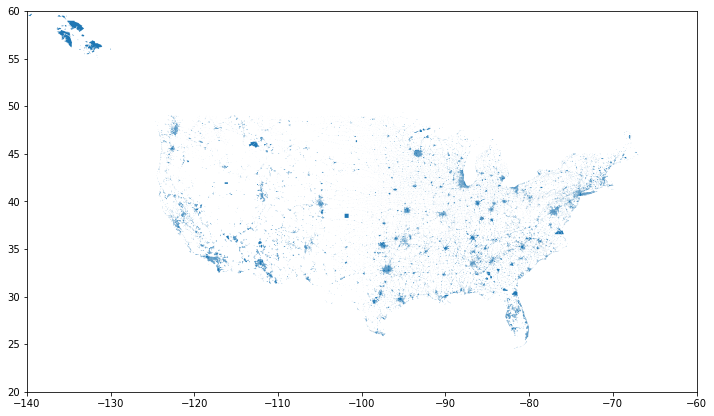

In [44]:
# basic plot of the CDP data
ax = cdps.plot(figsize=(12,12));
ax.set(xlim=(-140,-60), ylim=(20, 60)) # scale the figure with axes values

#### Read in SVIs as GeoDataframe

In [30]:
# read in raw census tract data from .zip and convert to geodataframe
svi = gpd.read_file(r"C:\NewMapsPlus\Map698\us-communities-fire\data\SVI2018_US.zip")

In [33]:
# inspect
type(svi)

geopandas.geodataframe.GeoDataFrame

In [34]:
# get file info
svi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 72837 entries, 0 to 72836
Columns: 127 entries, ST to geometry
dtypes: float64(65), geometry(1), int64(54), object(7)
memory usage: 70.6+ MB


In [50]:
# determine coordinate reference syst
svi.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [36]:
# look at the first 5 rows of data
svi.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry
0,01,ALABAMA,AL,01015,Calhoun,01015981901,"Census Tract 9819.01, Calhoun County, Alabama",24.243865,0,12,...,-999,-999,0,12,-999.0,-999.0,656,0.006105,0.339400,"POLYGON ((-86.01323 33.68426, -86.01224 33.687..."
1,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.646714,0,12,...,-999,-999,0,12,-999.0,-999.0,146,0.008752,0.420459,"POLYGON ((-86.01730 33.69662, -86.01704 33.698..."
2,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.926276,0,12,...,-999,-999,0,12,-999.0,-999.0,0,0.003508,0.330164,"POLYGON ((-85.78501 33.66554, -85.78318 33.666..."
3,01,ALABAMA,AL,01097,Mobile,01097003605,"Census Tract 36.05, Mobile County, Alabama",0.732300,899,316,...,-999,-999,33,36,3.7,4.1,5135,0.000180,0.060725,"POLYGON ((-88.19230 30.69524, -88.19097 30.695..."
4,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0,12,...,-999,-999,0,12,-999.0,-999.0,0,0.000536,0.105380,"MULTIPOLYGON (((-88.05337 30.50699, -88.05109 ..."


[(-140.0, -60.0), (20.0, 60.0)]

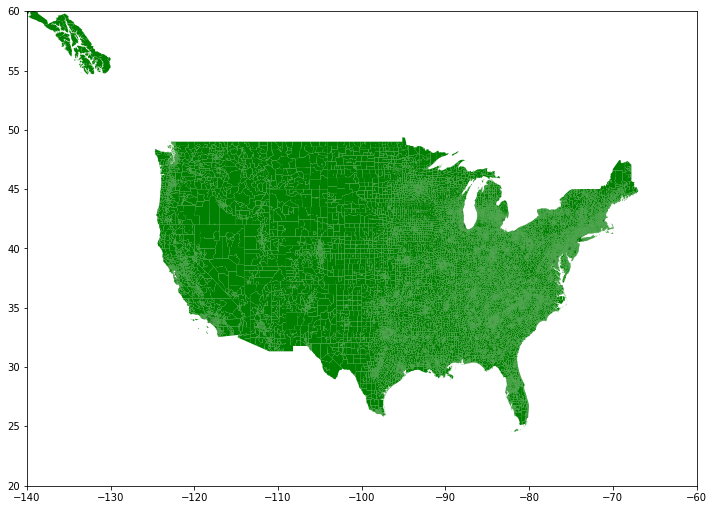

In [55]:
# have a look at the tract data in map form
ax = svi.plot(figsize=(12,12), color='green');
ax.set(xlim=(-140,-60), ylim=(20, 60)) # scale the figure with axes values

#### Open WFH Raster

In [13]:
# open wildfire hazard potential raster
whp = rio.open('data\whp2020_cls_conus.tif')

In [14]:
# get bounds
whp.bounds

BoundingBox(left=-2361825.000000001, bottom=258794.99999999814, right=2263814.999999999, top=3175604.999999998)

In [15]:
# lots of cells in the raster
whp.read()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [16]:
# get some general metadata about the raster including CRS
whp.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 17132,
 'height': 10803,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(270.0, 0.0, -2361825.000000001,
        0.0, -270.0, 3175604.999999998)}

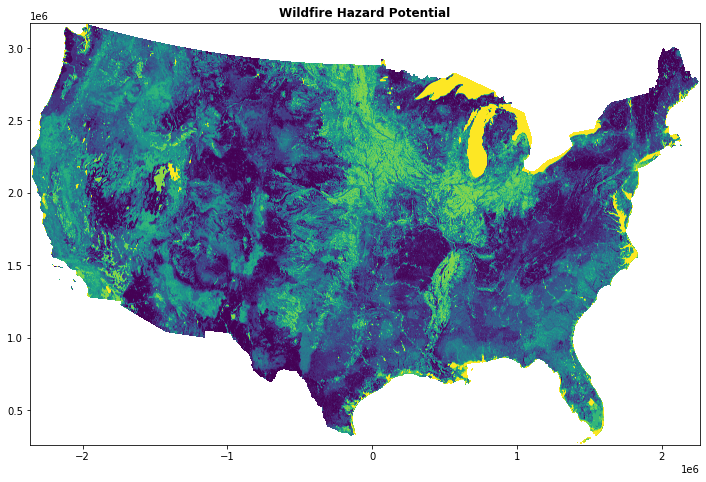

<AxesSubplot:title={'center':'Wildfire Hazard Potential'}>

In [56]:
# plot the raster
show(whp, title='Wildfire Hazard Potential')

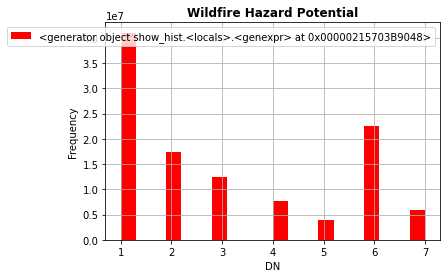

In [18]:
# plot distribution of hazard classes 1 being very low, 5 being very high and 7 being water
show_hist(whp, bins=20, title='Wildfire Hazard Potential')